In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trainedh5/DenseNet121_with_F1_Lightfield_Image.h5
/kaggle/input/trainedh5/Optimized_ResNet50_with_F1_Light_Image.h5
/kaggle/input/light-image/light images/Melanoma/0101_Dermatoscopic.png
/kaggle/input/light-image/light images/Melanoma/0121_Dermatoscopic.png
/kaggle/input/light-image/light images/Melanoma/0124_1_Dermatoscopic.jpg
/kaggle/input/light-image/light images/Melanoma/0138_Dermatoscopic.png
/kaggle/input/light-image/light images/Melanoma/0218_Dermatoscopic.png
/kaggle/input/light-image/light images/Melanoma/0230_4_Dermatoscopic.png
/kaggle/input/light-image/light images/Melanoma/159_5_Dermatoscopic.png
/kaggle/input/light-image/light images/Melanoma/0229_Dermatoscopic.png
/kaggle/input/light-image/light images/Melanoma/0230_2_Dermatoscopic.png
/kaggle/input/light-image/light images/Melanoma/0203_Dermatoscopic.png
/kaggle/input/light-image/light images/Melanoma/0124_2_Dermatoscopic.jpg
/kaggle/input/light-image/light images/Melanoma/0228_1_Dermatoscopic.png
/kaggle

Found 172 images belonging to 5 classes.
Found 40 images belonging to 5 classes.
Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.2853 - loss: 1.7610 - precision: 0.3410 - recall: 0.1275 - val_accuracy: 0.4750 - val_loss: 1.7436 - val_precision: 0.4750 - val_recall: 0.4750 - learning_rate: 5.0000e-05
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 538ms/step - accuracy: 0.5423 - loss: 1.3793 - precision: 0.5549 - recall: 0.3975 - val_accuracy: 0.4750 - val_loss: 1.4215 - val_precision: 0.4872 - val_recall: 0.4750 - learning_rate: 5.0000e-05
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 531ms/step - accuracy: 0.5350 - loss: 1.1594 - precision: 0.6752 - recall: 0.3667 - val_accuracy: 0.4750 - val_loss: 1.4139 - val_precision: 0.4872 - val_recall: 0.4750 - learning_rate: 5.0000e-05
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 513ms/step - accuracy: 0.6380 - loss: 0.9770 - precision: 0.7431 - recall: 0.4678 - val_accuracy: 0.4750 - val_loss: 1.6477 - val_precision: 0.4872 - val_recall: 0.4750 - learning_rate: 5.0000e-05
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 501ms/step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


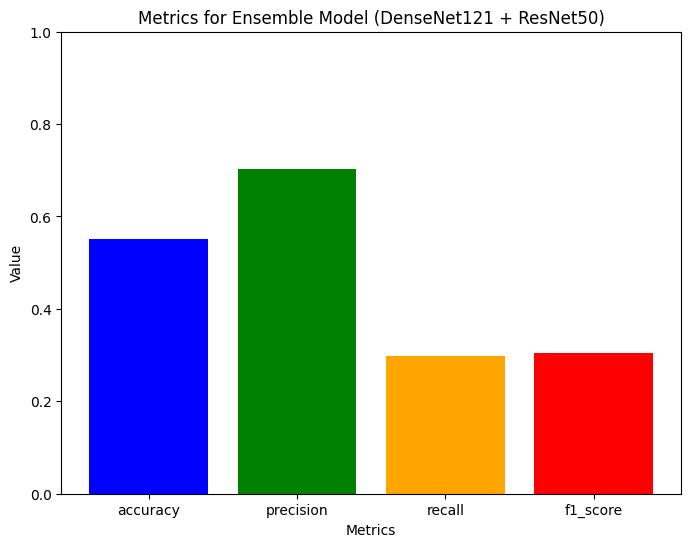

Ensemble predictions saved to /kaggle/working/ensemble_predictions.npy
✅ Ensembling of DenseNet121 and ResNet50 completed!


In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Paths for Kaggle
dataset_dir = "/kaggle/input/light-image/light images"
output_dir = "/kaggle/working"

# Parameters
input_size = (224, 224)
batch_size = 16
epochs = 100
patience = 10
learning_rate = 0.00005
fine_tune_lr = 1e-5  # For DenseNet121 fine-tuning

# Custom Image Preprocessing Function (consistent for both models)
def preprocess_image(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    image = cv2.GaussianBlur(image, (3, 3), 0)  # Using smaller blur for consistency
    image = image.astype(np.float32) / 255.0  # Normalize for ResNet50
    return image

# Custom ImageDataGenerator
class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, preprocessing_function=None, *args, **kwargs):
        self.custom_preprocessing = preprocessing_function
        super().__init__(*args, **kwargs)
    
    def flow_from_directory(self, *args, **kwargs):
        iterator = super().flow_from_directory(*args, **kwargs)
        original_next = iterator.__next__
        def new_next():
            batch_x, batch_y = original_next()
            if self.custom_preprocessing:
                batch_x = np.array([self.custom_preprocessing(img) for img in batch_x])
            return batch_x, batch_y
        iterator.__next__ = new_next
        return iterator

# Instantiate ImageDataGenerator
datagen = CustomImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Create generators
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # For consistent evaluation
)

num_classes = len(train_generator.class_indices)

# Define ResNet50 Model
def build_resnet50(input_shape=(224, 224, 3), num_classes=num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    for layer in base_model.layers:
        layer.trainable = True
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

# Define DenseNet121 Model
def build_densenet121(input_shape=(224, 224, 3), num_classes=num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    for layer in base_model.layers[:15]:
        layer.trainable = False
    for layer in base_model.layers[15:]:
        layer.trainable = True
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

# Fine-tune DenseNet121
def fine_tune_model(model, fine_tune_lr=fine_tune_lr):
    for layer in model.layers:
        layer.trainable = True
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# Train ResNet50
print("Training ResNet50...")
resnet50_model = build_resnet50(input_shape=input_size + (3,), num_classes=num_classes)
history_resnet = resnet50_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
resnet50_path = os.path.join(output_dir, "Optimized_ResNet50_with_F1.h5")
resnet50_model.save(resnet50_path)
print(f"ResNet50 saved to {resnet50_path}")

# Train DenseNet121 (initial training)
print("Training DenseNet121 (initial)...")
densenet121_model = build_densenet121(input_shape=input_size + (3,), num_classes=num_classes)
history_densenet = densenet121_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
initial_densenet_path = os.path.join(output_dir, "DenseNet121_initial_training.h5")
densenet121_model.save(initial_densenet_path)

# Fine-tune DenseNet121
print("Fine-tuning DenseNet121...")
densenet121_model_fine_tuned = fine_tune_model(densenet121_model)
history_fine_tune = densenet121_model_fine_tuned.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    initial_epoch=history_densenet.epoch[-1],
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
densenet121_path = os.path.join(output_dir, "Fine_Tuned_DenseNet121_with_F1.h5")
densenet121_model_fine_tuned.save(densenet121_path)
print(f"Fine-tuned DenseNet121 saved to {densenet121_path}")

# Load models for ensembling
model1 = load_model(densenet121_path, compile=False)
model2 = load_model(resnet50_path, compile=False)

# Generate predictions
print("Generating predictions from DenseNet121...")
validation_generator.reset()
preds1 = model1.predict(validation_generator, verbose=1)
print("Generating predictions from ResNet50...")
validation_generator.reset()
preds2 = model2.predict(validation_generator, verbose=1)

# Ensemble predictions (weighted averaging)
weight1 = 0.6  # Weight for DenseNet121
weight2 = 0.4  # Weight for ResNet50
ensemble_preds = (weight1 * preds1 + weight2 * preds2) / (weight1 + weight2)
ensemble_labels = np.argmax(ensemble_preds, axis=1)
true_labels = validation_generator.classes

# Evaluate ensemble
accuracy = accuracy_score(true_labels, ensemble_labels)
precision = precision_score(true_labels, ensemble_labels, average='macro')
recall = recall_score(true_labels, ensemble_labels, average='macro')
f1 = f1_score(true_labels, ensemble_labels, average='macro')

print(f"Ensemble Accuracy: {accuracy:.4f}")
print(f"Ensemble Precision: {precision:.4f}")
print(f"Ensemble Recall: {recall:.4f}")
print(f"Ensemble F1 Score: {f1:.4f}")

# Plot ensemble metrics
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
values = [accuracy, precision, recall, f1]
colors = ['blue', 'green', 'orange', 'red']
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=colors)
plt.title('Metrics for Ensemble Model (DenseNet121 + ResNet50)')
plt.ylim(0, 1)
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.show()

# Save ensemble predictions
ensemble_output_path = os.path.join(output_dir, "ensemble_predictions.npy")
np.save(ensemble_output_path, ensemble_preds)
print(f"Ensemble predictions saved to {ensemble_output_path}")

print("✅ Ensembling of DenseNet121 and ResNet50 completed!")

Found 172 images belonging to 5 classes.
Found 40 images belonging to 5 classes.
Class indices: {'Basal-cell Carcinoma': 0, 'Dermatofibroma': 1, 'Melanoma': 2, 'Nevus': 3, 'Seborrheic Keratosis': 4}
Training class distribution: Counter({3: 78, 0: 32, 4: 27, 2: 23, 1: 12})
Validation class distribution: Counter({3: 19, 0: 8, 4: 6, 2: 5, 1: 2})


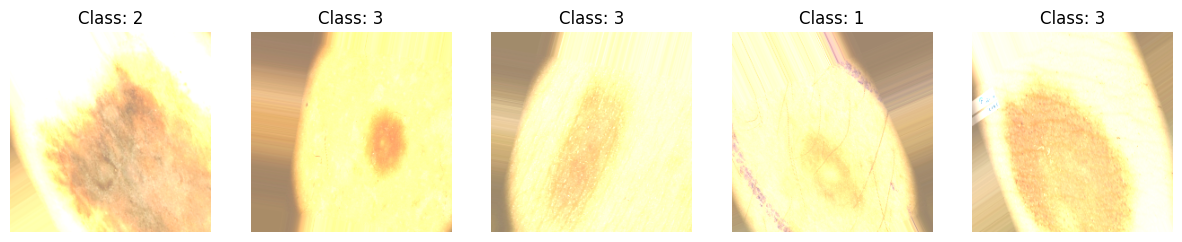

Class weights: {0: 1.075, 1: 2.8666666666666667, 2: 1.4956521739130435, 3: 0.441025641025641, 4: 1.2740740740740741}
Training ResNet50...
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.2651 - loss: 1.7415 - precision: 0.2871 - recall: 0.0855 - val_accuracy: 0.5250 - val_loss: 1.3351 - val_precision: 0.5455 - val_recall: 0.4500 - learning_rate: 3.0000e-04
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 510ms/step - accuracy: 0.5775 - loss: 1.0756 - precision: 0.6867 - recall: 0.4553 - val_accuracy: 0.5750 - val_loss: 1.5556 - val_precision: 0.6111 - val_recall: 0.5500 - learning_rate: 3.0000e-04
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 547ms/step - accuracy: 0.6718 - loss: 0.8744 - precision: 0.7467 - recall: 0.5953 - val_accuracy: 0.5000 - val_loss: 1.7067 - val_precision: 0.6061 - val_recall: 0.5000 - learning_rate: 3.0000e-04
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 533ms/step - accuracy: 0.7333 - loss: 0.7183 - precision: 0.7548 - recall: 0.6617 - val_accuracy: 0.5500 - val_loss: 3.0909 - val_precision: 0.5500 - val_recall: 0.5500 - learning_rate: 3.0000e-04
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 543ms/step -

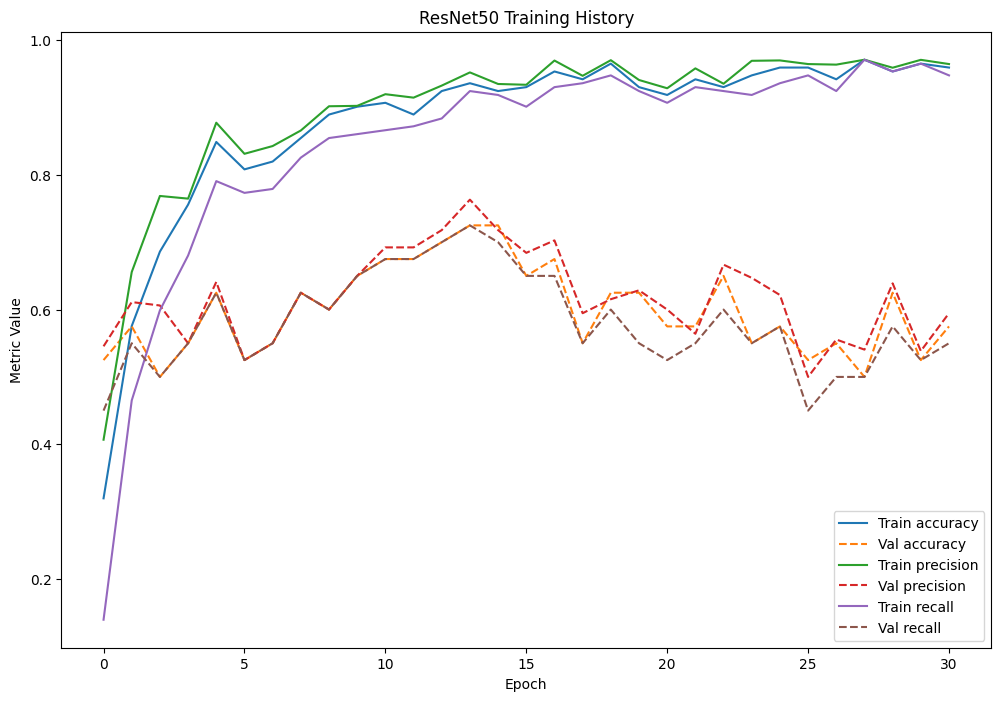

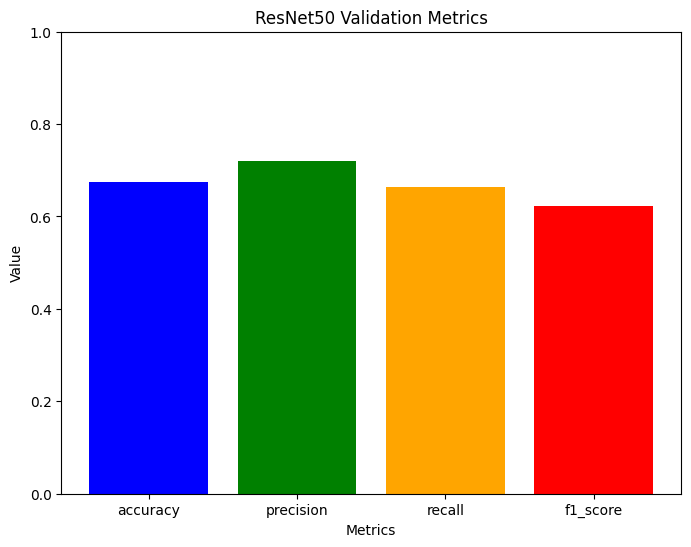

Training DenseNet121 (initial)...
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 231s 10s/step - accuracy: 0.2862 - loss: 1.7476 - precision: 0.5758 - recall: 0.1455 - val_accuracy: 0.5000 - val_loss: 1.3661 - val_precision: 0.6250 - val_recall: 0.1250 - learning_rate: 3.0000e-04
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 516ms/step - accuracy: 0.5142 - loss: 1.5089 - precision: 0.6801 - recall: 0.3640 - val_accuracy: 0.6250 - val_loss: 1.2791 - val_precision: 0.6000 - val_recall: 0.2250 - learning_rate: 3.0000e-04
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 487ms/step - accuracy: 0.6705 - loss: 0.8788 - precision: 0.8137 - recall: 0.5503 - val_accuracy: 0.6500 - val_loss: 1.3241 - val_precision: 0.8000 - val_recall: 0.5000 - learning_rate: 3.0000e-04
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 538ms/step - accuracy: 0.7229 - loss: 0.8286 - precision: 0.7955 - recall: 0.6429 - val_accuracy: 0.6500 - val_loss: 1.1620 - val_precision: 0.6857 - val_recall: 0.6000 - learning_rate: 3.0000e-04
Epoch 5

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


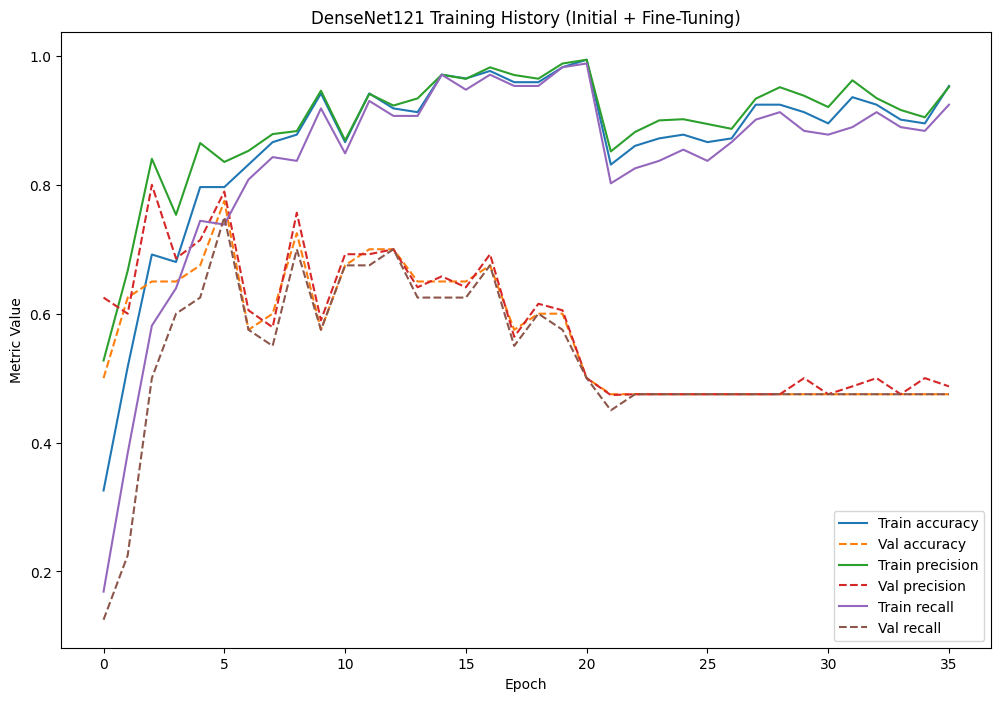

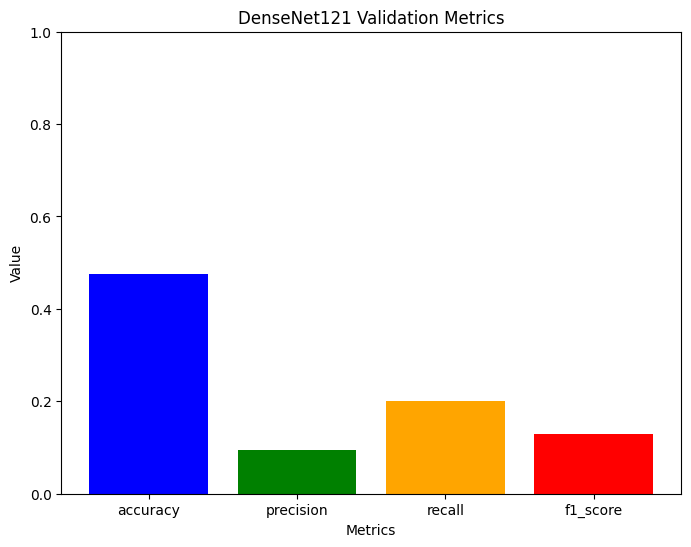

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Optimal Weights - DenseNet: 0.1, ResNet: 0.9 | Best F1 Score: 0.6814
📌 ResNet50 Performance:
  - Accuracy: 0.6750
  - Precision: 0.7197
  - Recall: 0.6629
  - F1 Score: 0.6235
📌 DenseNet121 Performance:
  - Accuracy: 0.4750
  - Precision: 0.0950
  - Recall: 0.2000
  - F1 Score: 0.1288
📌 Ensemble Model Performance:
  - Accuracy: 0.7500
  - Precision: 0.7645
  - Recall: 0.6573
  - F1 Score: 0.6814


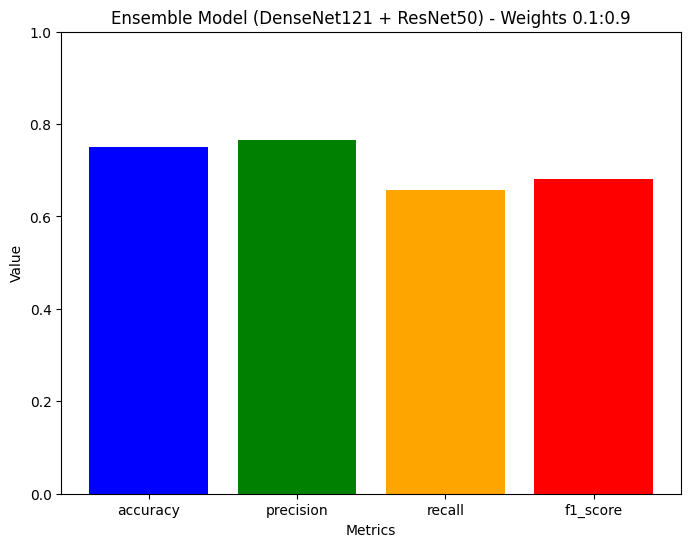

Ensemble predictions saved to /kaggle/working/ensemble_predictions.npy
✅ Ensembling completed!


In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter

# Paths
dataset_dir = "/kaggle/input/light-image/light images"
output_dir = "/kaggle/working"

# Parameters
input_size = (224, 224)
batch_size = 16
epochs = 100
patience = 15  # More lenient
learning_rate = 0.0003  # Increased
fine_tune_lr = 0.00001

# Preprocessing function
def preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Ensure RGB
    image = tf.keras.applications.resnet50.preprocess_input(image)  # ImageNet preprocessing
    return image

# Visualize a few images
def visualize_images(generator):
    batch_x, batch_y = next(generator)
    plt.figure(figsize=(15, 5))
    for i in range(min(5, batch_x.shape[0])):
        plt.subplot(1, 5, i+1)
        img = batch_x[i]  # ImageNet preprocessing shifts values, so we clip for display
        img = np.clip(img + [123.68, 116.779, 103.939], 0, 255).astype(np.uint8)  # Reverse mean subtraction for display
        plt.imshow(img)
        plt.title(f"Class: {np.argmax(batch_y[i])}")
        plt.axis('off')
    plt.show()

# Custom ImageDataGenerator
class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, preprocessing_function=None, *args, **kwargs):
        self.custom_preprocessing = preprocessing_function
        super().__init__(*args, **kwargs)
    
    def flow_from_directory(self, *args, **kwargs):
        iterator = super().flow_from_directory(*args, **kwargs)
        original_next = iterator.__next__
        def new_next():
            batch_x, batch_y = original_next()
            if self.custom_preprocessing:
                batch_x = np.array([self.custom_preprocessing(img) for img in batch_x])
            return batch_x, batch_y
        iterator.__next__ = new_next
        return iterator

# Data Generators
datagen = CustomImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print("Class indices:", train_generator.class_indices)

# Check class distribution
class_counts = Counter(train_generator.classes)
print("Training class distribution:", class_counts)
val_class_counts = Counter(validation_generator.classes)
print("Validation class distribution:", val_class_counts)

# Visualize some images
visualize_images(train_generator)

# Compute class weights
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / (num_classes * count) for cls, count in class_counts.items()}
print("Class weights:", class_weights)

# Define ResNet50 Model
def build_resnet50(input_shape=(224, 224, 3), num_classes=num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    for layer in base_model.layers:
        layer.trainable = True
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)  # Reduced size, lower L2
    x = Dropout(0.3)(x)  # Reduced dropout
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

# Define DenseNet121 Model
def build_densenet121(input_shape=(224, 224, 3), num_classes=num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    for layer in base_model.layers[:15]:
        layer.trainable = False
    for layer in base_model.layers[15:]:
        layer.trainable = True
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

def fine_tune_model(model, fine_tune_lr=fine_tune_lr):
    for layer in model.layers:
        layer.trainable = True
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# Train ResNet50
print("Training ResNet50...")
resnet50_model = build_resnet50(input_shape=input_size + (3,), num_classes=num_classes)
history_resnet = resnet50_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
    verbose=1
)
resnet50_path = os.path.join(output_dir, "Optimized_ResNet50_with_F1.h5")
resnet50_model.save(resnet50_path)
val_acc_resnet = max(history_resnet.history['val_accuracy'])
print(f"ResNet50 saved to {resnet50_path}, Best Val Accuracy: {val_acc_resnet:.4f}")

# Compute ResNet50 metrics
validation_generator.reset()
resnet_preds = resnet50_model.predict(validation_generator, verbose=1)
resnet_labels = np.argmax(resnet_preds, axis=1)
true_labels = validation_generator.classes
resnet_acc = accuracy_score(true_labels, resnet_labels)
resnet_prec = precision_score(true_labels, resnet_labels, average='macro')
resnet_rec = recall_score(true_labels, resnet_labels, average='macro')
resnet_f1 = f1_score(true_labels, resnet_labels, average='macro')

# Plot ResNet50
plt.figure(figsize=(12, 8))
for metric in ['accuracy', 'precision', 'recall']:
    plt.plot(history_resnet.history[metric], label=f'Train {metric}')
    plt.plot(history_resnet.history[f'val_{metric}'], label=f'Val {metric}', linestyle='--')
plt.title('ResNet50 Training History')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

resnet_metrics = ['accuracy', 'precision', 'recall', 'f1_score']
resnet_values = [resnet_acc, resnet_prec, resnet_rec, resnet_f1]
colors = ['blue', 'green', 'orange', 'red']
plt.figure(figsize=(8, 6))
plt.bar(resnet_metrics, resnet_values, color=colors)
plt.title('ResNet50 Validation Metrics')
plt.ylim(0, 1)
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.show()

# Train DenseNet121 (initial)
print("Training DenseNet121 (initial)...")
densenet121_model = build_densenet121(input_shape=input_size + (3,), num_classes=num_classes)
history_densenet = densenet121_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
    verbose=1
)
initial_densenet_path = os.path.join(output_dir, "DenseNet121_initial_training.h5")
densenet121_model.save(initial_densenet_path)

# Fine-tune DenseNet121
print("Fine-tuning DenseNet121...")
densenet121_model_fine_tuned = fine_tune_model(densenet121_model)
history_fine_tune = densenet121_model_fine_tuned.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    initial_epoch=history_densenet.epoch[-1],
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
    verbose=1
)
densenet121_path = os.path.join(output_dir, "Fine_Tuned_DenseNet121_with_F1.h5")
densenet121_model_fine_tuned.save(densenet121_path)
val_acc_densenet = max(history_fine_tune.history['val_accuracy'])
print(f"Fine-tuned DenseNet121 saved to {densenet121_path}, Best Val Accuracy: {val_acc_densenet:.4f}")

# Compute DenseNet121 metrics
validation_generator.reset()
densenet_preds = densenet121_model_fine_tuned.predict(validation_generator, verbose=1)
densenet_labels = np.argmax(densenet_preds, axis=1)
densenet_acc = accuracy_score(true_labels, densenet_labels)
densenet_prec = precision_score(true_labels, densenet_labels, average='macro')
densenet_rec = recall_score(true_labels, densenet_labels, average='macro')
densenet_f1 = f1_score(true_labels, densenet_labels, average='macro')

# Plot DenseNet121
plt.figure(figsize=(12, 8))
for metric in ['accuracy', 'precision', 'recall']:
    plt.plot(history_densenet.history[metric] + history_fine_tune.history[metric], label=f'Train {metric}')
    plt.plot(history_densenet.history[f'val_{metric}'] + history_fine_tune.history[f'val_{metric}'], label=f'Val {metric}', linestyle='--')
plt.title('DenseNet121 Training History (Initial + Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

densenet_metrics = ['accuracy', 'precision', 'recall', 'f1_score']
densenet_values = [densenet_acc, densenet_prec, densenet_rec, densenet_f1]
plt.figure(figsize=(8, 6))
plt.bar(densenet_metrics, densenet_values, color=colors)
plt.title('DenseNet121 Validation Metrics')
plt.ylim(0, 1)
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.show()

# Ensemble with grid search for weights
model1 = load_model(densenet121_path, compile=False)
model2 = load_model(resnet50_path, compile=False)

validation_generator.reset()
preds1 = model1.predict(validation_generator, verbose=1)
validation_generator.reset()
preds2 = model2.predict(validation_generator, verbose=1)

# Normalize predictions
preds1 = preds1 / preds1.sum(axis=1, keepdims=True)
preds2 = preds2 / preds2.sum(axis=1, keepdims=True)

best_f1 = 0
best_weights = (0, 0)
for w1 in np.arange(0, 1.1, 0.1):
    w2 = 1 - w1
    ensemble_preds = w1 * preds1 + w2 * preds2
    ensemble_labels = np.argmax(ensemble_preds, axis=1)
    f1 = f1_score(true_labels, ensemble_labels, average='macro')
    if f1 > best_f1:
        best_f1 = f1
        best_weights = (w1, w2)

w1, w2 = best_weights
print(f"Optimal Weights - DenseNet: {w1:.1f}, ResNet: {w2:.1f} | Best F1 Score: {best_f1:.4f}")

ensemble_preds = w1 * preds1 + w2 * preds2
ensemble_labels = np.argmax(ensemble_preds, axis=1)
ensemble_acc = accuracy_score(true_labels, ensemble_labels)
ensemble_prec = precision_score(true_labels, ensemble_labels, average='macro')
ensemble_rec = recall_score(true_labels, ensemble_labels, average='macro')
ensemble_f1 = f1_score(true_labels, ensemble_labels, average='macro')

# Print individual and ensemble performance
print(f"📌 ResNet50 Performance:\n  - Accuracy: {resnet_acc:.4f}\n  - Precision: {resnet_prec:.4f}\n  - Recall: {resnet_rec:.4f}\n  - F1 Score: {resnet_f1:.4f}")
print(f"📌 DenseNet121 Performance:\n  - Accuracy: {densenet_acc:.4f}\n  - Precision: {densenet_prec:.4f}\n  - Recall: {densenet_rec:.4f}\n  - F1 Score: {densenet_f1:.4f}")
print(f"📌 Ensemble Model Performance:\n  - Accuracy: {ensemble_acc:.4f}\n  - Precision: {ensemble_prec:.4f}\n  - Recall: {ensemble_rec:.4f}\n  - F1 Score: {ensemble_f1:.4f}")

# Plot ensemble
plt.figure(figsize=(8, 6))
ensemble_metrics = ['accuracy', 'precision', 'recall', 'f1_score']
ensemble_values = [ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1]
plt.bar(ensemble_metrics, ensemble_values, color=colors)
plt.title(f'Ensemble Model (DenseNet121 + ResNet50) - Weights {w1:.1f}:{w2:.1f}')
plt.ylim(0, 1)
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.show()

ensemble_output_path = os.path.join(output_dir, "ensemble_predictions.npy")
np.save(ensemble_output_path, ensemble_preds)
print(f"Ensemble predictions saved to {ensemble_output_path}")

print("✅ Ensembling completed!")

Found 212 images belonging to 5 classes.
Class indices: {'Basal-cell Carcinoma': 0, 'Dermatofibroma': 1, 'Melanoma': 2, 'Nevus': 3, 'Seborrheic Keratosis': 4}
Training class distribution: Counter({3: 97, 0: 40, 4: 33, 2: 28, 1: 14})


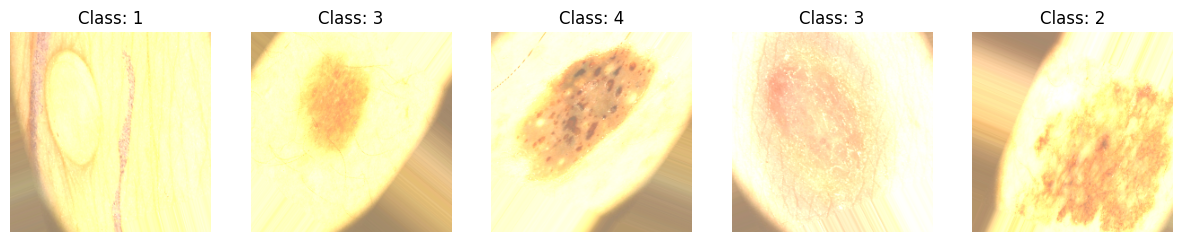

Class weights: {0: 1.06, 1: 3.0285714285714285, 2: 1.5142857142857142, 3: 0.43711340206185567, 4: 1.284848484848485}
Training ResNet50...
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.3309 - loss: 1.7641 - precision: 0.4802 - recall: 0.1317 - learning_rate: 3.0000e-04
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 427ms/step - accuracy: 0.6111 - loss: 1.1598 - precision: 0.8070 - recall: 0.4130 - learning_rate: 3.0000e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 407ms/step - accuracy: 0.6630 - loss: 0.9914 - precision: 0.7910 - recall: 0.5672 - learning_rate: 3.0000e-04
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 443ms/step - accuracy: 0.7303 - loss: 0.9279 - precision: 0.7953 - recall: 0.6569 - learning_rate: 3.0000e-04
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - accuracy: 0.6931 - loss: 0.7731 - precision: 0.7549 - recall: 0.5462 - learning_rate: 3.0000e-04
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 464ms/step - accuracy: 0.7362 - loss: 0.6527 - precision: 0.8489 - recall: 0.6191 - learning_rate: 3.0000e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 468ms/step - accuracy: 0.7488 - loss: 0.9420 - precisi

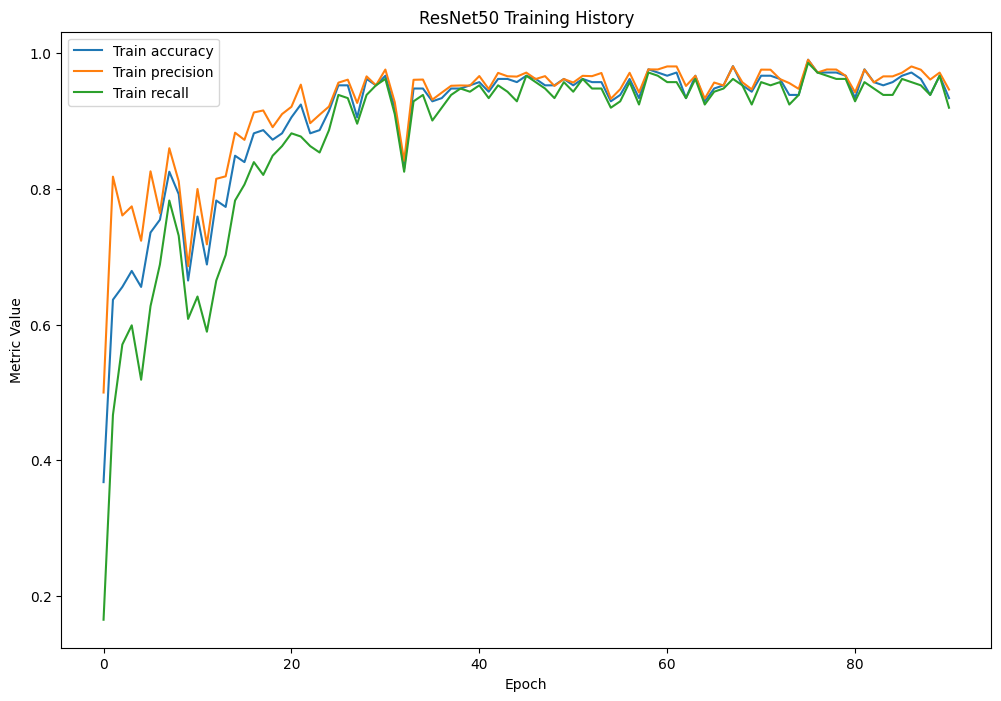

Training DenseNet121 (initial)...
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 244s 8s/step - accuracy: 0.3019 - loss: 1.8209 - precision: 0.3812 - recall: 0.1776 - learning_rate: 3.0000e-04
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 384ms/step - accuracy: 0.4833 - loss: 1.2664 - precision: 0.6106 - recall: 0.2569 - learning_rate: 3.0000e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 429ms/step - accuracy: 0.6624 - loss: 0.9672 - precision: 0.7706 - recall: 0.5659 - learning_rate: 3.0000e-04
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 430ms/step - accuracy: 0.6851 - loss: 0.7313 - precision: 0.7670 - recall: 0.6181 - learning_rate: 3.0000e-04
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 438ms/step - accuracy: 0.7684 - loss: 0.6457 - precision: 0.8068 - recall: 0.7289 - learning_rate: 3.0000e-04
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 426ms/step - accuracy: 0.8418 - loss: 0.5297 - precision: 0.8729 - recall: 0.8290 - learning_rate: 3.0000e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 385ms/s

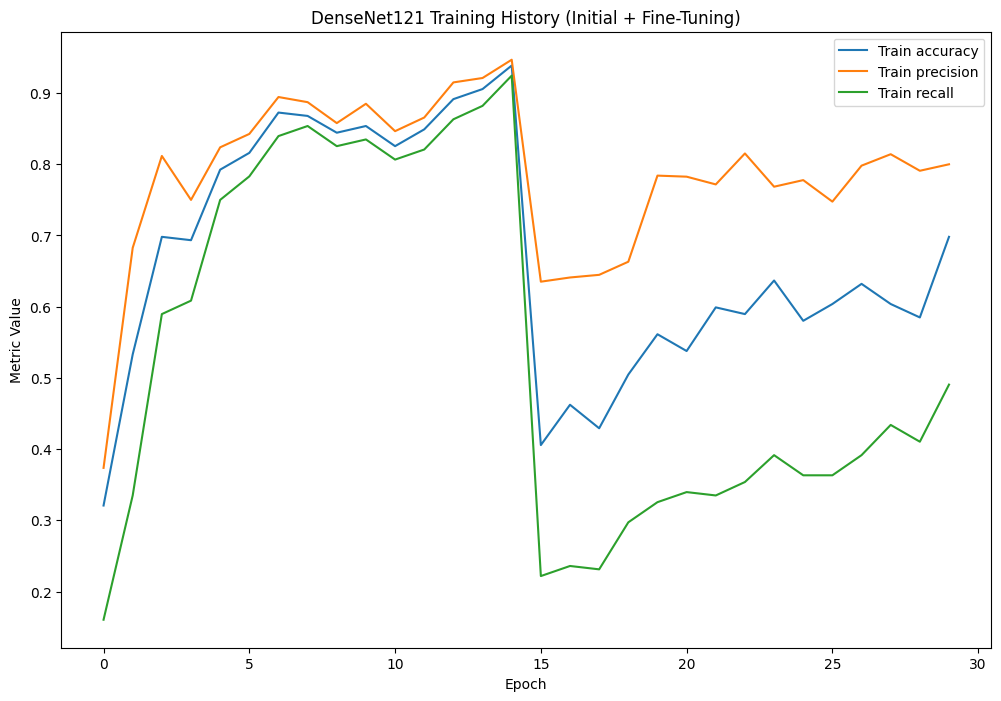

14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 873ms/step
Optimal Weights - DenseNet: 0.1, ResNet: 0.9 | Best Train F1 Score: 0.2211
📌 ResNet50 Performance (Training Data):
  - Accuracy: 0.3019
  - Precision: 0.2210
  - Recall: 0.2211
  - F1 Score: 0.2210
📌 DenseNet121 Performance (Training Data):
  - Accuracy: 0.3962
  - Precision: 0.2044
  - Recall: 0.1884
  - F1 Score: 0.1421
📌 Ensemble Model Performance (Training Data):
  - Accuracy: 0.3019
  - Precision: 0.2211
  - Recall: 0.2211
  - F1 Score: 0.2211


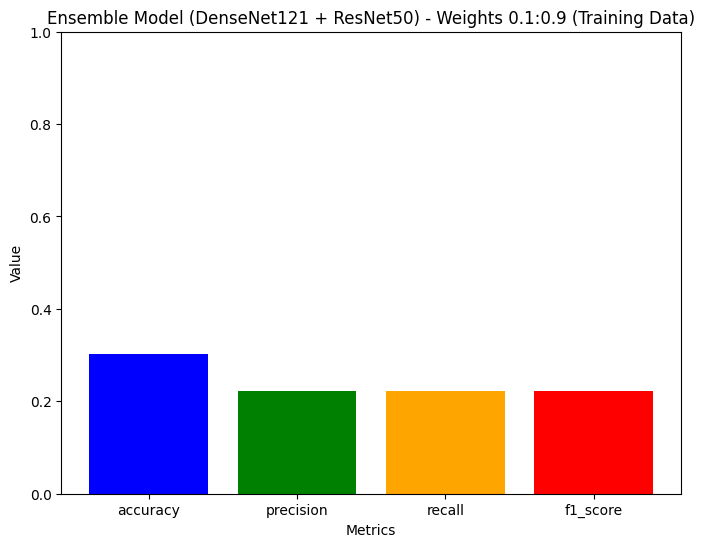

Ensemble predictions saved to /kaggle/working/ensemble_predictions.npy
✅ Ensembling completed!


In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter

# Paths
dataset_dir = "/kaggle/input/light-image/light images"
output_dir = "/kaggle/working"

# Parameters
input_size = (224, 224)
batch_size = 16
epochs = 100
learning_rate = 0.0003  # Increased
fine_tune_lr = 0.00001

# Preprocessing function
def preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Ensure RGB
    image = tf.keras.applications.resnet50.preprocess_input(image)  # ImageNet preprocessing
    return image

# Visualize a few images
def visualize_images(generator):
    batch_x, batch_y = next(generator)
    plt.figure(figsize=(15, 5))
    for i in range(min(5, batch_x.shape[0])):
        plt.subplot(1, 5, i+1)
        img = batch_x[i]
        img = np.clip(img + [123.68, 116.779, 103.939], 0, 255).astype(np.uint8)  # Reverse mean subtraction for display
        plt.imshow(img)
        plt.title(f"Class: {np.argmax(batch_y[i])}")
        plt.axis('off')
    plt.show()

# Custom ImageDataGenerator
class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, preprocessing_function=None, *args, **kwargs):
        self.custom_preprocessing = preprocessing_function
        super().__init__(*args, **kwargs)
    
    def flow_from_directory(self, *args, **kwargs):
        iterator = super().flow_from_directory(*args, **kwargs)
        original_next = iterator.__next__
        def new_next():
            batch_x, batch_y = original_next()
            if self.custom_preprocessing:
                batch_x = np.array([self.custom_preprocessing(img) for img in batch_x])
            return batch_x, batch_y
        iterator.__next__ = new_next
        return iterator

# Data Generator (no validation split)
datagen = CustomImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

num_classes = len(train_generator.class_indices)
print("Class indices:", train_generator.class_indices)

# Check class distribution
class_counts = Counter(train_generator.classes)
print("Training class distribution:", class_counts)

# Visualize some images
visualize_images(train_generator)

# Compute class weights
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / (num_classes * count) for cls, count in class_counts.items()}
print("Class weights:", class_weights)

# Define ResNet50 Model
def build_resnet50(input_shape=(224, 224, 3), num_classes=num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    for layer in base_model.layers:
        layer.trainable = True
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

# Define DenseNet121 Model
def build_densenet121(input_shape=(224, 224, 3), num_classes=num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    for layer in base_model.layers[:15]:
        layer.trainable = False
    for layer in base_model.layers[15:]:
        layer.trainable = True
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

def fine_tune_model(model, fine_tune_lr=fine_tune_lr):
    for layer in model.layers:
        layer.trainable = True
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

# Callbacks (no validation, so monitor training loss)
early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-7)

# Train ResNet50
print("Training ResNet50...")
resnet50_model = build_resnet50(input_shape=input_size + (3,), num_classes=num_classes)
history_resnet = resnet50_model.fit(
    train_generator,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
    verbose=1
)
resnet50_path = os.path.join(output_dir, "Optimized_ResNet50_with_F1.h5")
resnet50_model.save(resnet50_path)
train_acc_resnet = max(history_resnet.history['accuracy'])
print(f"ResNet50 saved to {resnet50_path}, Best Train Accuracy: {train_acc_resnet:.4f}")

# Plot ResNet50 Training History
plt.figure(figsize=(12, 8))
for metric in ['accuracy', 'precision', 'recall']:
    plt.plot(history_resnet.history[metric], label=f'Train {metric}')
plt.title('ResNet50 Training History')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

# Train DenseNet121 (initial)
print("Training DenseNet121 (initial)...")
densenet121_model = build_densenet121(input_shape=input_size + (3,), num_classes=num_classes)
history_densenet = densenet121_model.fit(
    train_generator,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
    verbose=1
)
initial_densenet_path = os.path.join(output_dir, "DenseNet121_initial_training.h5")
densenet121_model.save(initial_densenet_path)

# Fine-tune DenseNet121
print("Fine-tuning DenseNet121...")
densenet121_model_fine_tuned = fine_tune_model(densenet121_model)
history_fine_tune = densenet121_model_fine_tuned.fit(
    train_generator,
    epochs=epochs,
    initial_epoch=history_densenet.epoch[-1],
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
    verbose=1
)
densenet121_path = os.path.join(output_dir, "Fine_Tuned_DenseNet121_with_F1.h5")
densenet121_model_fine_tuned.save(densenet121_path)
train_acc_densenet = max(history_fine_tune.history['accuracy'])
print(f"Fine-tuned DenseNet121 saved to {densenet121_path}, Best Train Accuracy: {train_acc_densenet:.4f}")

# Plot DenseNet121 Training History
plt.figure(figsize=(12, 8))
for metric in ['accuracy', 'precision', 'recall']:
    plt.plot(history_densenet.history[metric] + history_fine_tune.history[metric], label=f'Train {metric}')
plt.title('DenseNet121 Training History (Initial + Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

# Load models for ensemble
model1 = load_model(densenet121_path, compile=False)
model2 = load_model(resnet50_path, compile=False)

# Generate predictions on training data
train_generator.reset()
preds1 = model1.predict(train_generator, verbose=1)
train_generator.reset()
preds2 = model2.predict(train_generator, verbose=1)

# True labels from training data
true_labels = train_generator.classes

# Normalize predictions
preds1 = preds1 / preds1.sum(axis=1, keepdims=True)
preds2 = preds2 / preds2.sum(axis=1, keepdims=True)

# Grid search for optimal weights based on training F1 score
best_f1 = 0
best_weights = (0, 0)
for w1 in np.arange(0, 1.1, 0.1):
    w2 = 1 - w1
    ensemble_preds = w1 * preds1 + w2 * preds2
    ensemble_labels = np.argmax(ensemble_preds, axis=1)
    f1 = f1_score(true_labels, ensemble_labels, average='macro')
    if f1 > best_f1:
        best_f1 = f1
        best_weights = (w1, w2)

w1, w2 = best_weights
print(f"Optimal Weights - DenseNet: {w1:.1f}, ResNet: {w2:.1f} | Best Train F1 Score: {best_f1:.4f}")

# Ensemble predictions with optimal weights
ensemble_preds = w1 * preds1 + w2 * preds2
ensemble_labels = np.argmax(ensemble_preds, axis=1)
ensemble_acc = accuracy_score(true_labels, ensemble_labels)
ensemble_prec = precision_score(true_labels, ensemble_labels, average='macro')
ensemble_rec = recall_score(true_labels, ensemble_labels, average='macro')
ensemble_f1 = f1_score(true_labels, ensemble_labels, average='macro')

# Compute individual model metrics on training data
resnet_labels = np.argmax(preds2, axis=1)
resnet_acc = accuracy_score(true_labels, resnet_labels)
resnet_prec = precision_score(true_labels, resnet_labels, average='macro')
resnet_rec = recall_score(true_labels, resnet_labels, average='macro')
resnet_f1 = f1_score(true_labels, resnet_labels, average='macro')

densenet_labels = np.argmax(preds1, axis=1)
densenet_acc = accuracy_score(true_labels, densenet_labels)
densenet_prec = precision_score(true_labels, densenet_labels, average='macro')
densenet_rec = recall_score(true_labels, densenet_labels, average='macro')
densenet_f1 = f1_score(true_labels, densenet_labels, average='macro')

# Print performance
print(f"📌 ResNet50 Performance (Training Data):\n  - Accuracy: {resnet_acc:.4f}\n  - Precision: {resnet_prec:.4f}\n  - Recall: {resnet_rec:.4f}\n  - F1 Score: {resnet_f1:.4f}")
print(f"📌 DenseNet121 Performance (Training Data):\n  - Accuracy: {densenet_acc:.4f}\n  - Precision: {densenet_prec:.4f}\n  - Recall: {densenet_rec:.4f}\n  - F1 Score: {densenet_f1:.4f}")
print(f"📌 Ensemble Model Performance (Training Data):\n  - Accuracy: {ensemble_acc:.4f}\n  - Precision: {ensemble_prec:.4f}\n  - Recall: {ensemble_rec:.4f}\n  - F1 Score: {ensemble_f1:.4f}")

# Plot ensemble metrics
plt.figure(figsize=(8, 6))
ensemble_metrics = ['accuracy', 'precision', 'recall', 'f1_score']
ensemble_values = [ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1]
colors = ['blue', 'green', 'orange', 'red']
plt.bar(ensemble_metrics, ensemble_values, color=colors)
plt.title(f'Ensemble Model (DenseNet121 + ResNet50) - Weights {w1:.1f}:{w2:.1f} (Training Data)')
plt.ylim(0, 1)
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.show()

# Save ensemble predictions
ensemble_output_path = os.path.join(output_dir, "ensemble_predictions.npy")
np.save(ensemble_output_path, ensemble_preds)
print(f"Ensemble predictions saved to {ensemble_output_path}")

print("✅ Ensembling completed!")

Generating predictions from DenseNet121...
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step
Generating predictions from ResNet50...
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
✅ Optimal Weights - DenseNet: 0.1, ResNet: 0.9 | Best F1 Score: 1.0000
📌 ResNet50 Performance:
  - Accuracy: 1.0000
  - Precision: 1.0000
  - Recall: 1.0000
  - F1 Score: 1.0000
📌 DenseNet121 Performance:
  - Accuracy: 0.5000
  - Precision: 0.2000
  - Recall: 0.3000
  - F1 Score: 0.2333
📌 Ensemble Model Performance:
  - Accuracy: 1.0000
  - Precision: 1.0000
  - Recall: 1.0000
  - F1 Score: 1.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


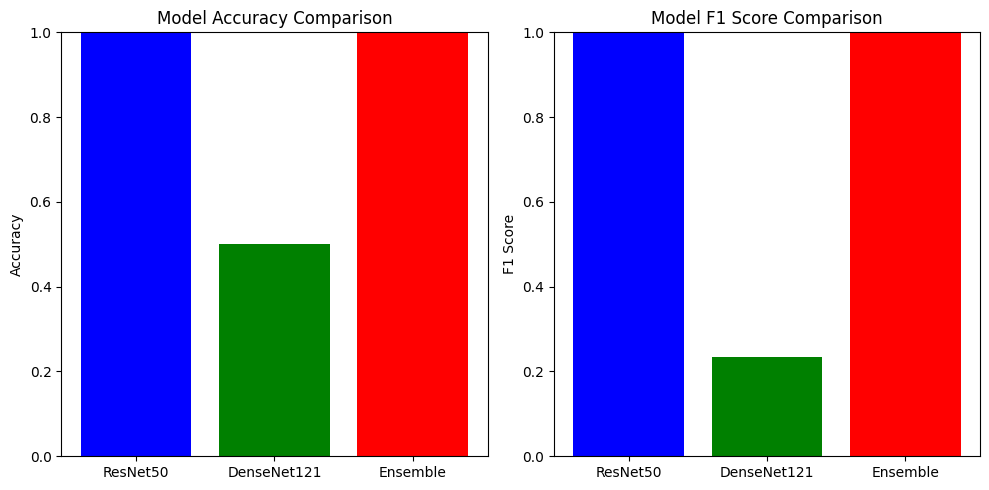

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


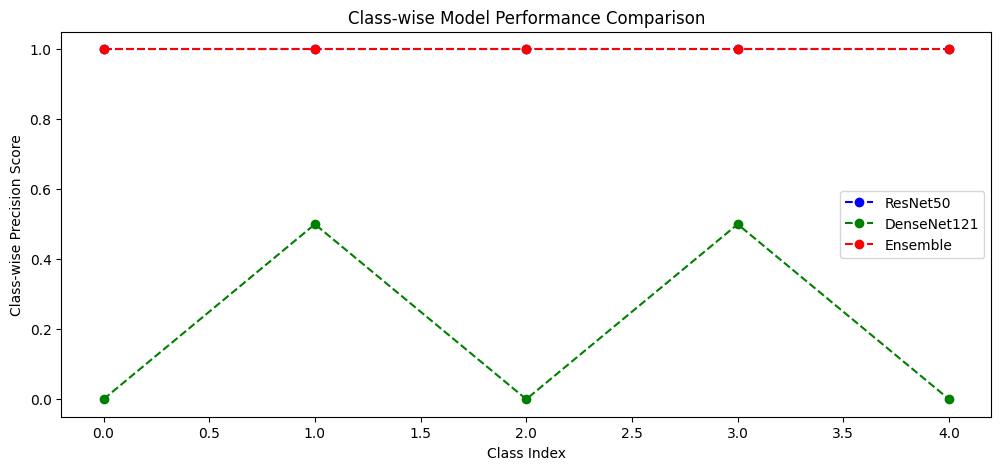

✅ Ensemble predictions saved to /kaggle/working/ensemble_predictions.npy


In [5]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Paths for trained models
densenet121_path = "/kaggle/working/Fine_Tuned_DenseNet121_with_F1.h5"
resnet50_path = "/kaggle/working/Optimized_ResNet50_with_F1.h5"

# Load trained models
model1 = load_model(densenet121_path, compile=False)  # DenseNet121
model2 = load_model(resnet50_path, compile=False)  # ResNet50

# Generate predictions
print("Generating predictions from DenseNet121...")
validation_generator.reset()
preds1 = model1.predict(validation_generator, verbose=1)

print("Generating predictions from ResNet50...")
validation_generator.reset()
preds2 = model2.predict(validation_generator, verbose=1)

# True labels
true_labels = validation_generator.classes

# ================================
# 1️⃣ Find Optimal Weights for Ensemble
# ================================
best_f1 = 0
best_w1, best_w2 = 0, 0
for w1 in np.arange(0.1, 1.0, 0.1):  # Testing different weight ratios
    w2 = 1 - w1
    ensemble_preds = (w1 * preds1 + w2 * preds2) / (w1 + w2)
    ensemble_labels = np.argmax(ensemble_preds, axis=1)

    f1 = f1_score(true_labels, ensemble_labels, average='macro')
    
    if f1 > best_f1:
        best_f1 = f1
        best_w1, best_w2 = w1, w2

print(f"✅ Optimal Weights - DenseNet: {best_w1}, ResNet: {best_w2} | Best F1 Score: {best_f1:.4f}")

# Apply optimized ensemble
ensemble_preds = (best_w1 * preds1 + best_w2 * preds2) / (best_w1 + best_w2)
ensemble_labels = np.argmax(ensemble_preds, axis=1)

# ================================
# 2️⃣ Evaluate Performance
# ================================
def evaluate_model(predictions, model_name):
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    print(f"📌 {model_name} Performance:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall: {recall:.4f}")
    print(f"  - F1 Score: {f1:.4f}")
    return accuracy, precision, recall, f1

# Evaluate all models
acc_resnet, prec_resnet, rec_resnet, f1_resnet = evaluate_model(preds2, "ResNet50")
acc_densenet, prec_densenet, rec_densenet, f1_densenet = evaluate_model(preds1, "DenseNet121")
acc_ensemble, prec_ensemble, rec_ensemble, f1_ensemble = evaluate_model(ensemble_preds, "Ensemble Model")

# ================================
# 3️⃣ Plot Performance Comparisons
# ================================
models = ['ResNet50', 'DenseNet121', 'Ensemble']
accuracies = [acc_resnet, acc_densenet, acc_ensemble]
f1_scores = [f1_resnet, f1_densenet, f1_ensemble]

plt.figure(figsize=(10, 5))

# Accuracy Comparison
plt.subplot(1, 2, 1)
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

# F1 Score Comparison
plt.subplot(1, 2, 2)
plt.bar(models, f1_scores, color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.title("Model F1 Score Comparison")

plt.tight_layout()
plt.show()

# ================================
# 4️⃣ Class-wise Performance Analysis
# ================================
class_wise_f1_resnet = precision_score(true_labels, np.argmax(preds2, axis=1), average=None)
class_wise_f1_densenet = precision_score(true_labels, np.argmax(preds1, axis=1), average=None)
class_wise_f1_ensemble = precision_score(true_labels, ensemble_labels, average=None)

plt.figure(figsize=(12, 5))
plt.plot(class_wise_f1_resnet, label="ResNet50", marker='o', linestyle='dashed', color='blue')
plt.plot(class_wise_f1_densenet, label="DenseNet121", marker='o', linestyle='dashed', color='green')
plt.plot(class_wise_f1_ensemble, label="Ensemble", marker='o', linestyle='dashed', color='red')
plt.xlabel("Class Index")
plt.ylabel("Class-wise Precision Score")
plt.title("Class-wise Model Performance Comparison")
plt.legend()
plt.show()

# ================================
# 5️⃣ Save Predictions
# ================================
ensemble_output_path = os.path.join("/kaggle/working", "ensemble_predictions.npy")
np.save(ensemble_output_path, ensemble_preds)
print(f"✅ Ensemble predictions saved to {ensemble_output_path}")
